In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
# import creating_anomaly_new as canomal
import numpy as np
from random import shuffle

In [2]:
cd ..

/home/jurgen/PycharmProjects/SygnalAnalysis


In [3]:
press_sep_data = pd.read_csv("datasets/DATA/Press_Sep/PressSep_1m.csv", delimiter=";" )
press_sep_data = press_sep_data.drop(press_sep_data.columns[0], axis=1)
press_sep_data= press_sep_data.dropna()
press_sep_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889455 entries, 0 to 889471
Data columns (total 5 columns):
Item         889455 non-null object
UTCTime      889455 non-null object
LocalTime    889455 non-null object
Value        889455 non-null float64
Quality      889455 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 40.7+ MB


In [4]:
press_sep_data.head()

,Item,UTCTime,LocalTime,Value,Quality
0,May.kust1.AGZU.ya.unOverpress_Plant,01.04.2017 1:00,01.04.2017 8:00,0.48,262336
1,May.kust1.AGZU.ya.unOverpress_Plant,01.04.2017 1:00,01.04.2017 8:00,0.48,262336
2,May.kust1.AGZU.ya.unOverpress_Plant,01.04.2017 1:01,01.04.2017 8:01,0.49,262336
3,May.kust1.AGZU.ya.unOverpress_Plant,01.04.2017 1:02,01.04.2017 8:02,0.49,262336
4,May.kust1.AGZU.ya.unOverpress_Plant,01.04.2017 1:02,01.04.2017 8:02,0.49,262336


# Frequency analysis

In [5]:
#https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/

# First vizualization Sample 

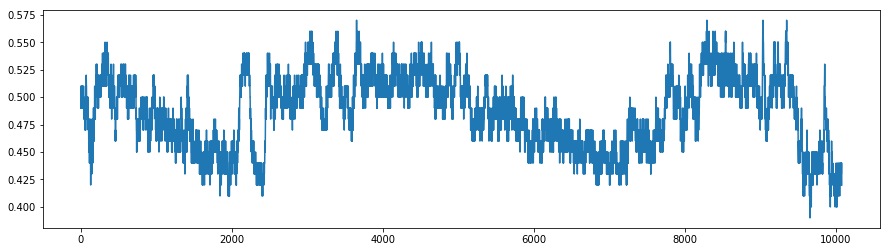

In [6]:
data = press_sep_data['Value'][14000: 14000+10080].values
figure, ax = plt.subplots(figsize=(15,4))
ax.plot(data)

# Second vizualization Sample

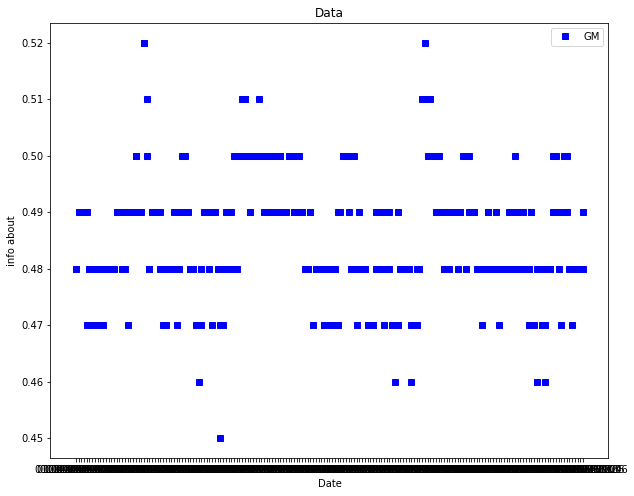

In [7]:
plt.figure(figsize=(10, 8))
plt.plot(press_sep_data['LocalTime'][: 300], press_sep_data['Value'][: 300], 'bs', label = 'GM')
# plt.plot(cars['Date'], cars['tesla_cap'], 'r-', label = 'TESLA')
plt.xlabel('Date'); plt.ylabel('info about'); plt.title('Data')
plt.legend();

# Third Visualization Example

# Autocorrelation

In [8]:
type(press_sep_data["Value"][:1000])

pandas.core.series.Series

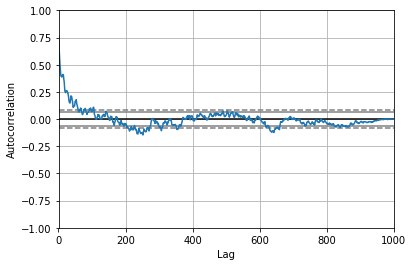

In [9]:
pd.plotting.autocorrelation_plot(pd.to_numeric(press_sep_data["Value"][0:1000]))
plt.show()

# Fouire transform

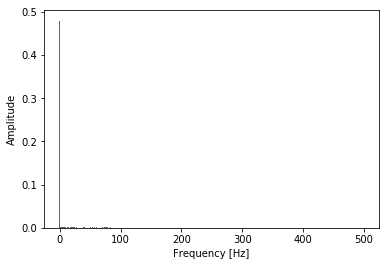

In [10]:
t = np.linspace(0, 0.5, 500)

fft = np.fft.fft(press_sep_data["Value"][:1000])
T = t[1] - t[0]  # sampling interval 
N = press_sep_data["Value"][:1000].size

# 1/T = frequency
f = np.linspace(0, 1 / T, N)

plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.bar(f[:N // 2], np.abs(fft)[:N // 2] * 1 / N, width=1.5)  # 1 / N is a normalization factor
plt.show()

# Anomaly Generator

In [12]:
from core.generator.signal_generator import SignalGenerator, NoiseGenerator

In [14]:

df = pd.read_csv("datasets/DATA/Press_Sep/PressSep_1bism.csv", delimiter=";")
noise_generator = NoiseGenerator(df['Value'][:14000].values)
noise_generator.slice_signals()
noise_generator.generate_anomaly()

another generating noise anomaly type


AttributeError: 'Signal' object has no attribute 'anomaly_window'

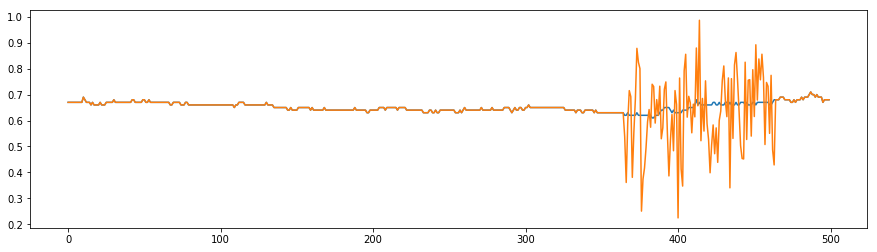

In [16]:
figure, ax = plt.subplots(figsize=(15,4))
ax.plot(noise_generator.signal_samples[132].values)
ax.plot(noise_generator.anomaly_signal_samples[132].values)
ax.plot(noise_generator.anomaly_signal_samples[132].anomaly_window)

NameError: name 'anom' is not defined

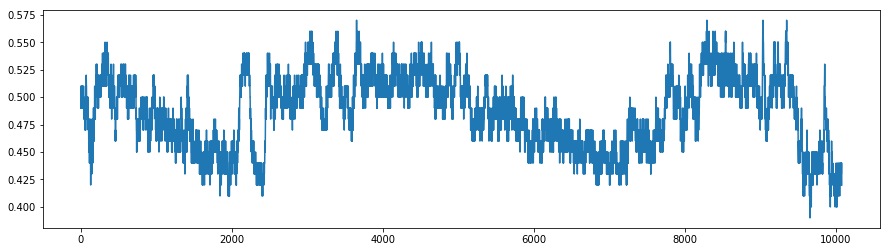

In [17]:
# anomaly = anom['Value'][14000: 14000+10080].values
figure, ax = plt.subplots(figsize=(15,4))
ax.plot(data)
ax.plot(anom)
ax.plot(mask)

In [7]:
print(len(mask))

10080


# Window rolling 

In [15]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [16]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    trace = go.Scatter(
            x = df.UTCTime,
            y = df["Value"],
            mode = 'lines',
            name = "Value"
        )
    data.append(trace)
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

plotly_df(press_sep_data[:1000], title = "Separate Data")

## moving average rolling

In [58]:
# Скользящее среднее 
def moving_average(series, n):
    return np.average(series[-n:])

def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(series, label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

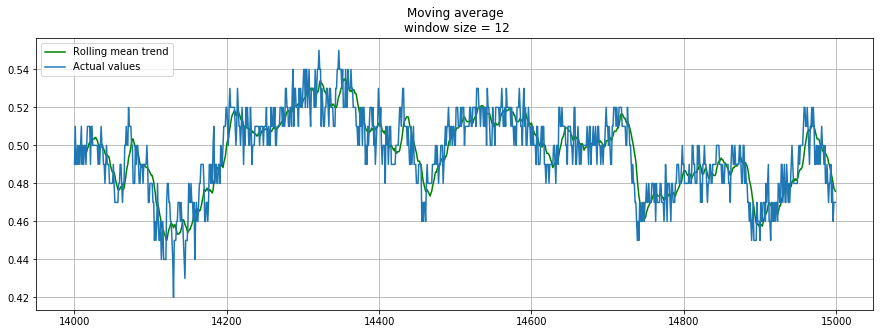

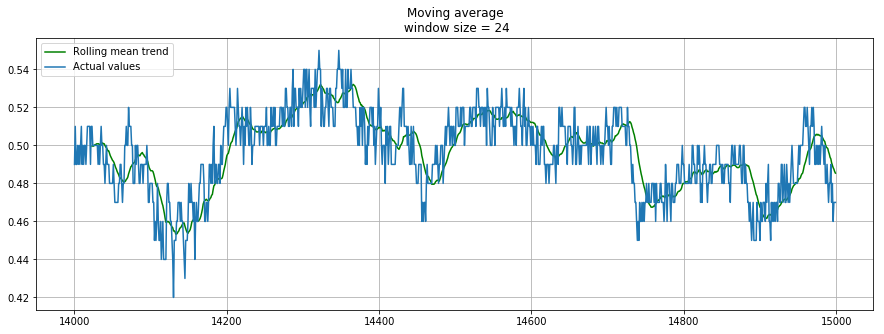

In [59]:
plotMovingAverage(press_sep_data["Value"][14000: 14000 + 1000], 12) # сглаживаем по дням
plotMovingAverage(press_sep_data["Value"][14000: 14000 + 1000], 24) # сглаживаем по неделям

## exponential smoothing

In [60]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

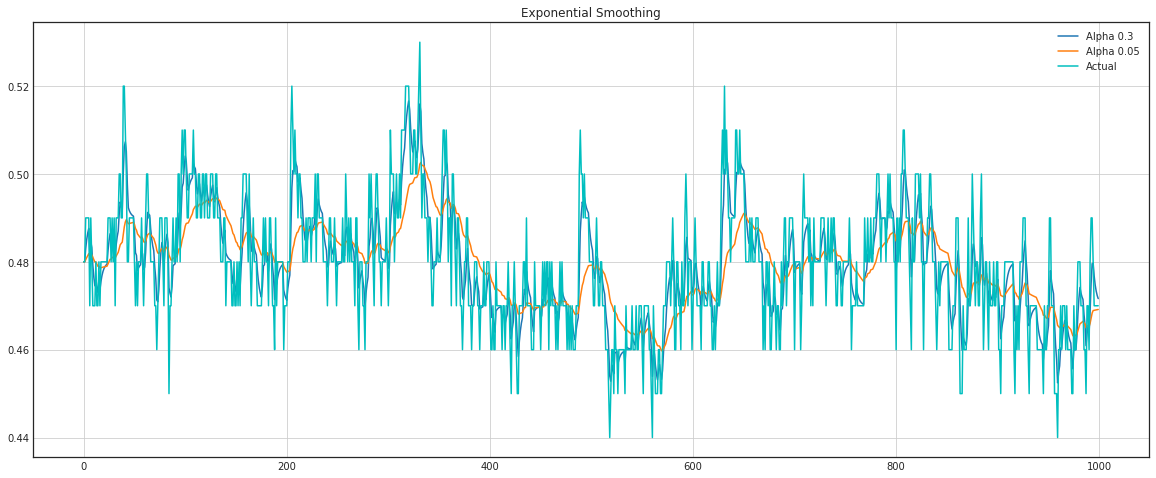

In [61]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(press_sep_data["Value"][:1000], alpha), label="Alpha {}".format(alpha))
    plt.plot(press_sep_data["Value"][:1000].values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

## double exponential smoothing

In [1]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

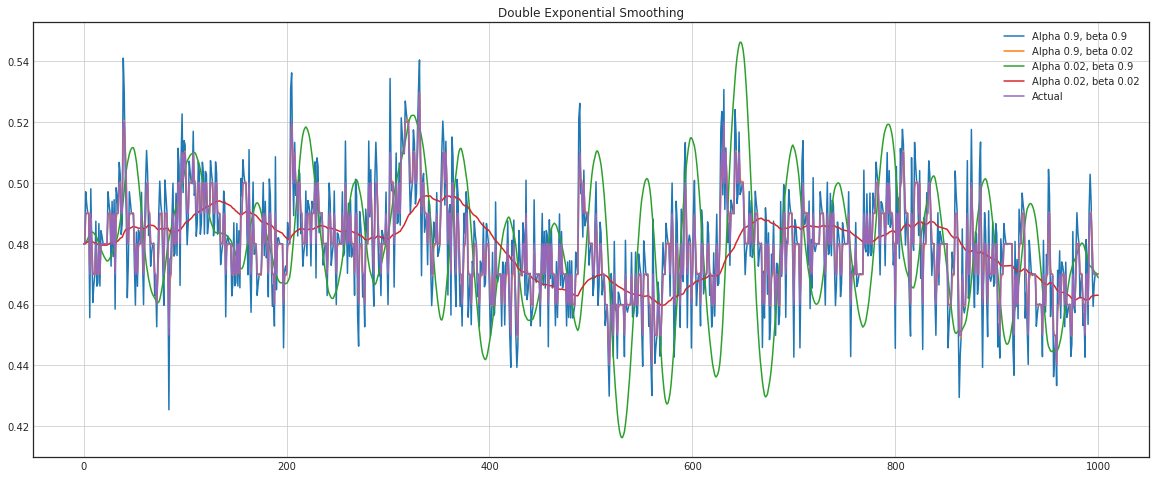

In [63]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(press_sep_data["Value"][:1000], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(press_sep_data["Value"][:1000].values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

## HoltWinters smoothing 

In [64]:
import numpy as np

class HoltWinters:
    
    """
        Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
        https://fedcsis.org/proceedings/2012/pliks/118.pdf
        
        
        # series - исходный временной ряд
        # slen - длина сезона
        # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
        # n_preds - горизонт предсказаний
        # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
        
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                
                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                
            
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])


            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
                
                
                
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])


# cross-validation on a rolling basis

В данном блоке есть построение по hotwinters также пример метода 
Implementation of Brutlag's algorithm in Anomaly Detection 3.0
необходимо изучить статью и понять каким образом в ней находятся аномалии 

In [65]:
dataset = press_sep_data[:2000]

In [66]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

In [67]:
%%time
data = dataset["Value"][:-500] # отложим часть данных для тестирования
print(data)
# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0       0.48
1       0.48
2       0.49
3       0.49
4       0.49
5       0.49
6       0.47
7       0.49
8       0.48
9       0.47
10      0.47
11      0.47
12      0.48
13      0.47
14      0.47
15      0.48
16      0.47
17      0.48
18      0.48
19      0.48
20      0.48
21      0.48
22      0.48
23      0.48
24      0.49
25      0.49
26      0.49
27      0.48
28      0.49
29      0.48
        ... 
1470    0.46
1471    0.45
1472    0.47
1473    0.46
1474    0.45
1475    0.46
1476    0.46
1477    0.46
1478    0.45
1479    0.44
1480    0.44
1481    0.45
1482    0.45
1483    0.45
1484    0.44
1485    0.44
1486    0.45
1487    0.45
1488    0.45
1489    0.45
1490    0.45
1491    0.45
1492    0.45
1493    0.45
1494    0.45
1495    0.45
1496    0.46
1497    0.47
1498    0.47
1499    0.45
Name: Value, Length: 1500, dtype: float64
0.00827921737254056 0.0043461119430511785 0.0
Wall time: 4.52 s


In [68]:
# Передаем оптимальные значения модели, 
data = press_sep_data["Value"][0:2000]
model = HoltWinters(data[:-128], slen = 24*7, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 128, scaling_factor = 2.56)
model.triple_exponential_smoothing()

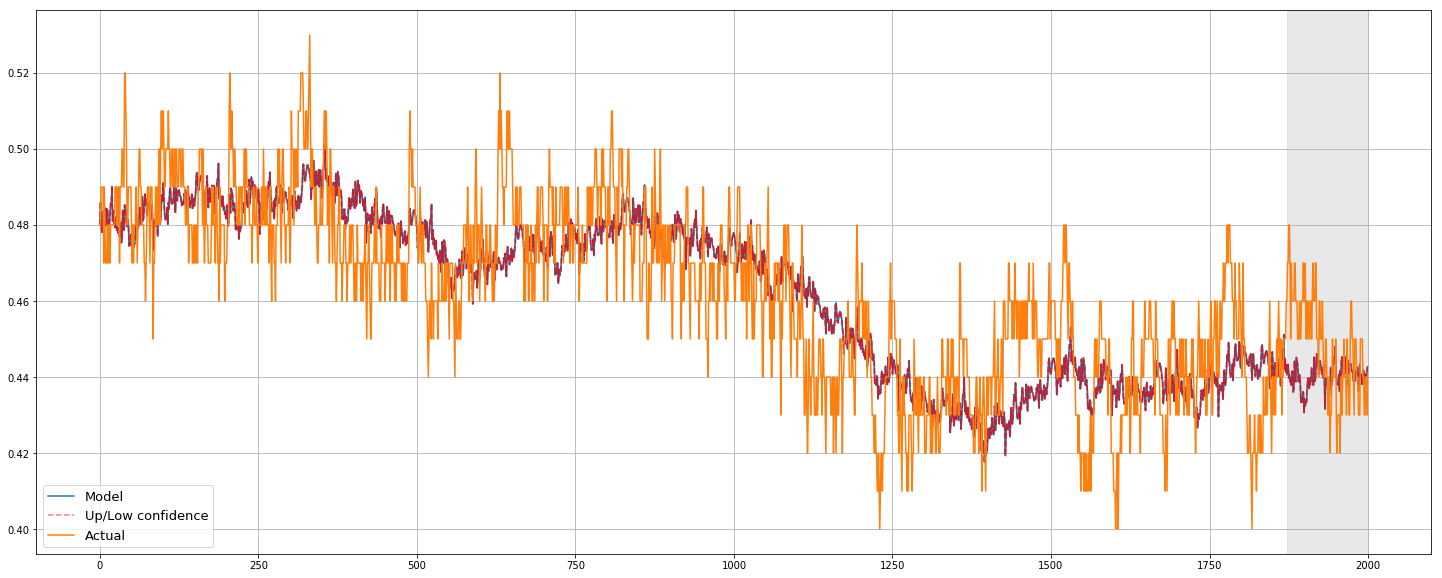

In [69]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
#     plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

plotHoltWinters()

# Небольшой пример наличия стационарности в шуме и последовательном ряду 

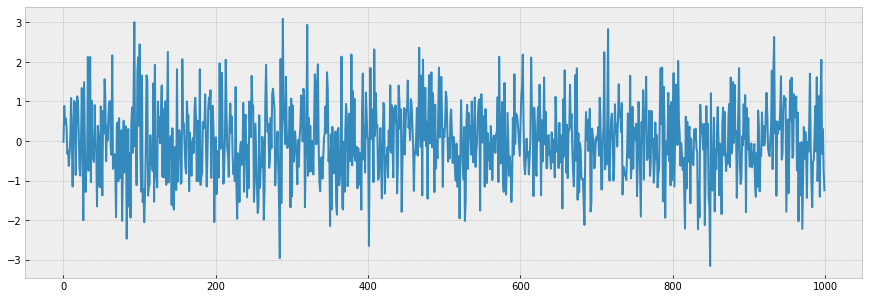

In [70]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)
    

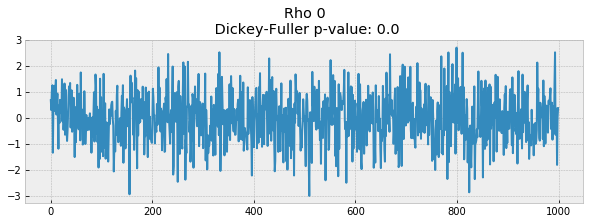

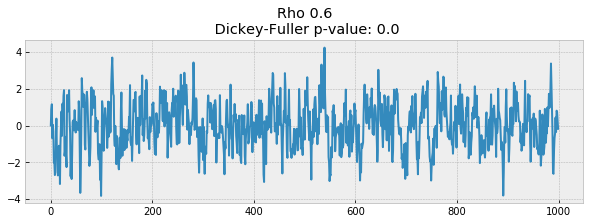

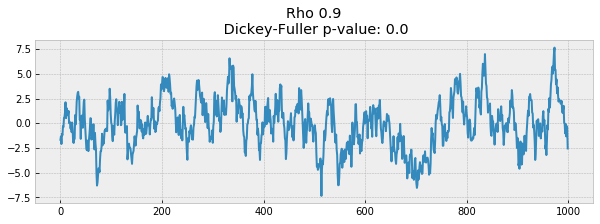

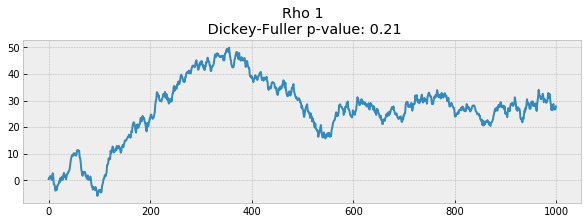

In [71]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))

for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

# Пример приведения ряда к стационарным значениям 

Критерий Дики-Фуллера: p=0.003684


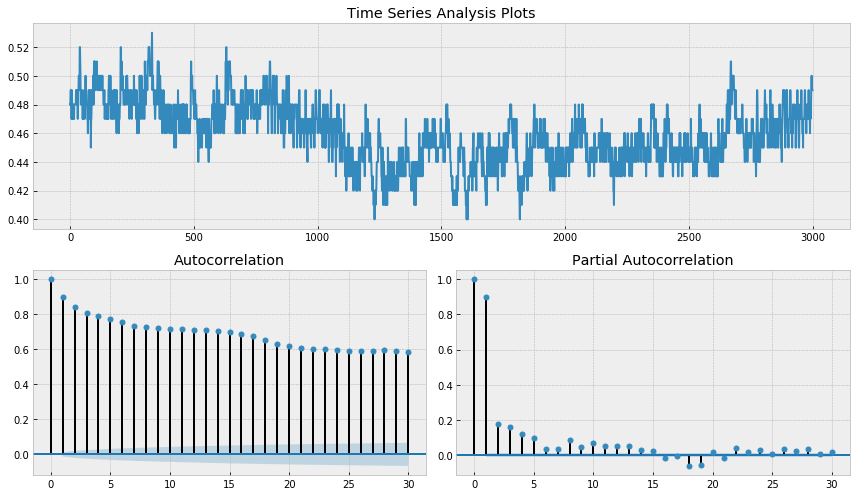

In [72]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(press_sep_data["Value"][:3000], lags=30)

# Пример стабилизации дисперсии преобразованием Бокса-Кокса.

                                  Item          UTCTime        LocalTime  \
0  May.kust1.AGZU.ya.unOverpress_Plant  01.04.2017 1:00  01.04.2017 8:00   
1  May.kust1.AGZU.ya.unOverpress_Plant  01.04.2017 1:00  01.04.2017 8:00   
2  May.kust1.AGZU.ya.unOverpress_Plant  01.04.2017 1:01  01.04.2017 8:01   
3  May.kust1.AGZU.ya.unOverpress_Plant  01.04.2017 1:02  01.04.2017 8:02   
4  May.kust1.AGZU.ya.unOverpress_Plant  01.04.2017 1:02  01.04.2017 8:02   

   Value  Quality  
0   0.48   262336  
1   0.48   262336  
2   0.49   262336  
3   0.49   262336  
4   0.49   262336  
Критерий Дики-Фуллера: p=0.003365
Оптимальный параметр преобразования Бокса-Кокса: -1.751313


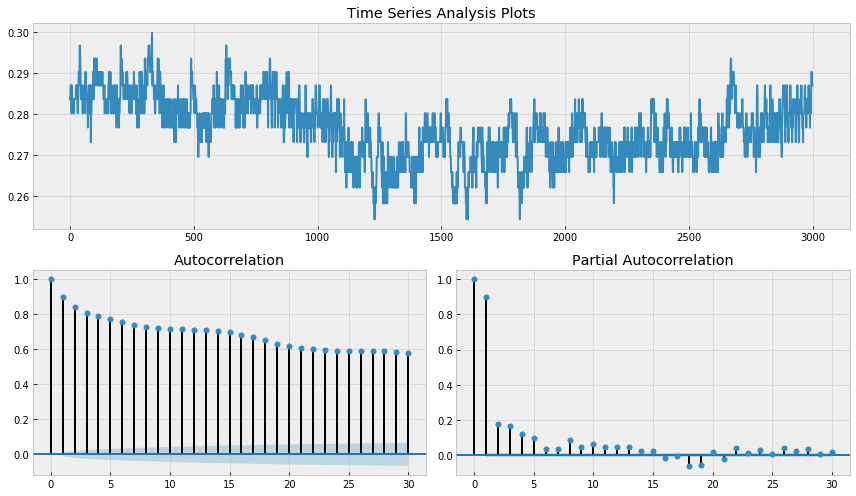

In [73]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data = press_sep_data[:3000].copy()
print(data.head())
data['Value_box_koks'], lmbda = scs.boxcox(data["Value"]+1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data["Value_box_koks"], lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера: p=0.000000


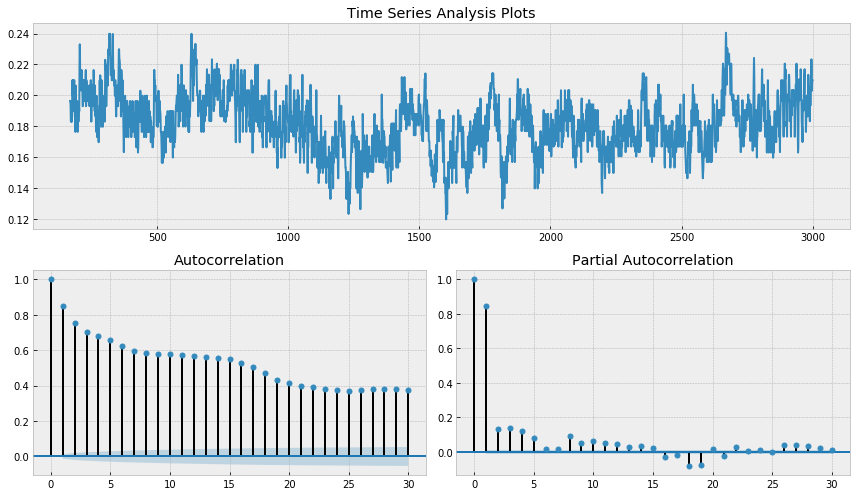

In [74]:
data['Value_box_koks_season'] = data["Value"] - data["Value_box_koks"].shift(24*7)
tsplot(data['Value_box_koks_season'][24*7:], lags=30)

Критерий Дики-Фуллера: p=0.000000


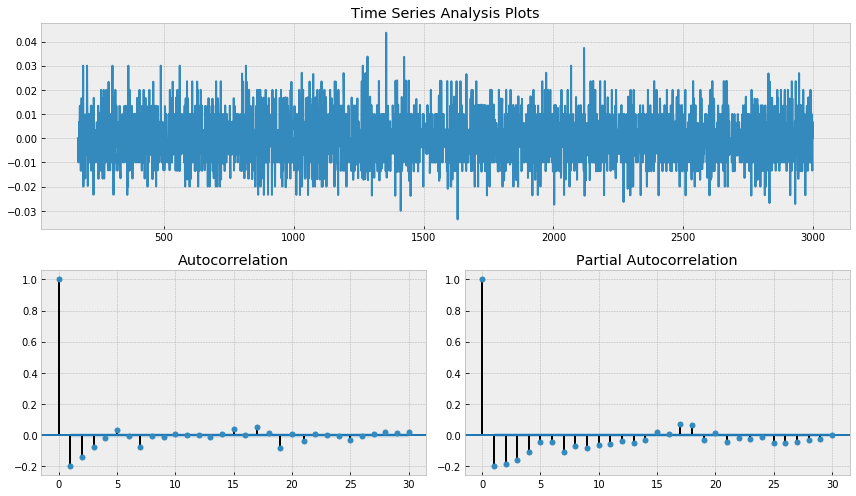

In [75]:
# data['Value_box_koks_season_diff'] = data.Value_box_koks_season - data.Value_box_koks_season.shift(1)
# tsplot(data["Value_box_koks_season_diff"][24*7+1:], lags=30)

data['Value_box_koks_season_diff'] = data["Value_box_koks_season"] - data["Value_box_koks_season"].shift(1)
tsplot(data["Value_box_koks_season_diff"][24*7+1:], lags=30)


# Построение ARIMA модели - у меня не работает от слова совсем крашиться при подсчете коэффициентов - виснет вся система
Почему то у меня не работает, виснет на этапе обучения - попробовать запустить как скрипт

In [27]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [ ]:
%%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data["Value"], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24*7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\jurgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
  1%|▊                                                                               | 1/100 [01:34<2:36:23, 94.78s/it]

In [ ]:
%%time
best_model = sm.tsa.statespace.SARIMAX(data.Users_box, order=(4, d, 3), 
                                        seasonal_order=(4, D, 1, 24)).fit(disp=-1)
print(best_model.summary()) 

# Feature exctraction